# TP3 - Frequency Domain
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: (FILL IN YOUR NAMES AND LASTNAMES)

## GOAL

In this lab we will:
- put into practice the computation of the DFT of an image, and learn to interpret the result. 
- Design and apply bandpass and Notch filters. 
- Replicate the use of the DCT for image compression in Jpeg.

## 0. Preparation 

### 0.1 Import the required modules


In [1]:
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io as io
from skimage.transform import resize

### 0.2 Define the main image folder
Make sure the subsequent parts of this notebook refer to this definition IMDIR. **When evaluating your notebook I should only need to change the path here** to run the entire notebook.

In [2]:
IMDIR = "./images/"
print(os.listdir(IMDIR))



['Fourier', 'Frequency', 'jpeg', 'PhaseMag']


### 0.2 Read and display the images
Check that you can read and display all the provided images. Do not include this cell, the code nor its ouput in the final report

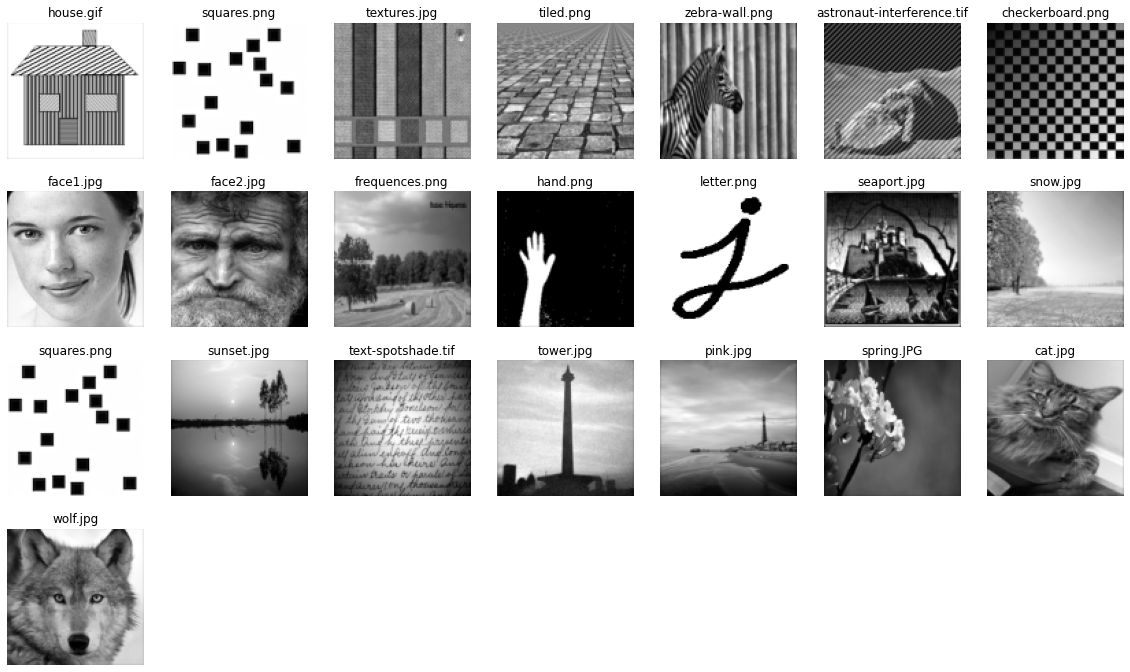

In [3]:
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]
            
fig=plt.figure()

im_counter = 1
for root, dirnames, filenames in os.walk(IMDIR):
    for filename in filenames:
        f = os.path.join(root, filename)
        
        #filter only image files with the following format
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            
            # print the paths to current filename if nothing is being found
            # print(filename)
            
            # read the image 
            im = io.imread(f,as_gray=True)
            im = resize(im,(100,100),mode='constant')

            # display it
            plt.subplot(5,7,im_counter)
            plt.imshow(im, cmap='gray')
            plt.title(filename)
            plt.axis('off')
            im_counter +=1 


plt.show()



## 1. The Discrete Fourier Transform



**In the report:** Resume the steps and explain the DFTs for each image

### 1.1 Computing and visualizing the DFT  


In this exercise we will compute and visualize a DFT using numpy's fft functions:
- ```np.fft.fft2```: computes the two-dimensional FFT of an image.
- ```np.fft.fftshift```: center the frecuencies in the middle of the image
- ```np.fft.ifftshift```: reverses the centering
- ```np.fft.ifft2```: inverse fourier transform
- ```np.real```: takes the real components of a complex number
- ```np.abs```: recovers the magnitude of a complex number
- ```np.angle```: recovers the phase of a complex number 
- ```np.log```: computes the logarithm

Apply the functions above to the images in the ```Fourier``` folder. Display in a single row for each image:

**a)** the original image 

**b)** the magnitude of its fft (scaled logarithmically)

**c)** the magnitude of its **centered(shifted)** fft (scaled logarithmically)

**c)** the inverse fft of the above transformed image (all the steps shouls be reversed)

**d) For each image explain how the information in the image relates to its representation in the frequency domain**




./images/Fourier\house.gif


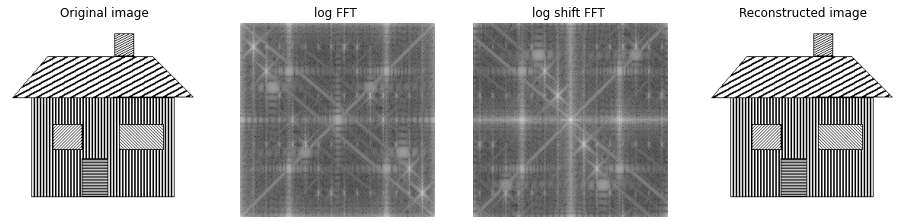

./images/Fourier\squares.png


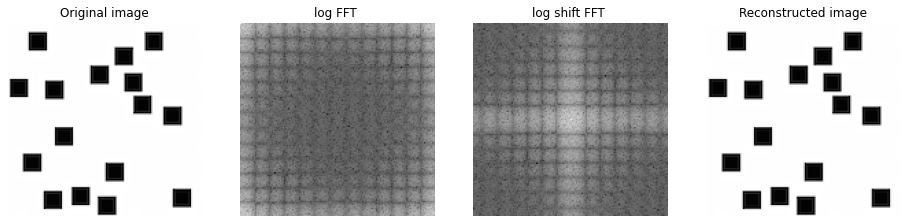

./images/Fourier\textures.jpg


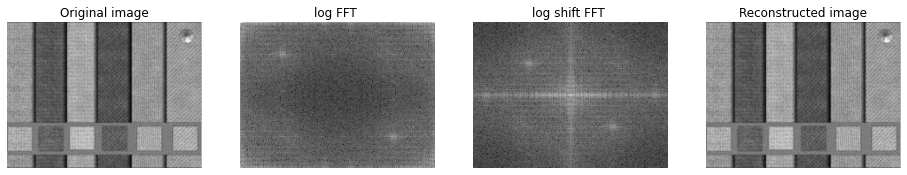

./images/Fourier\tiled.png


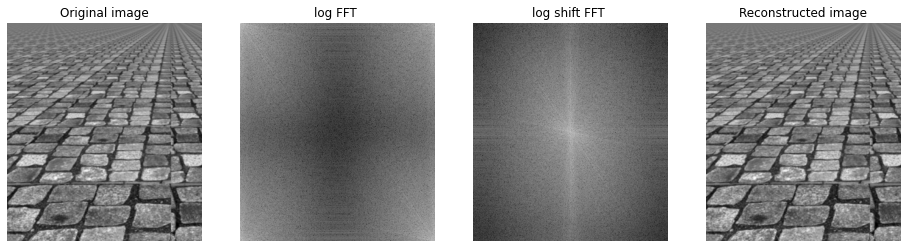

./images/Fourier\zebra-wall.png


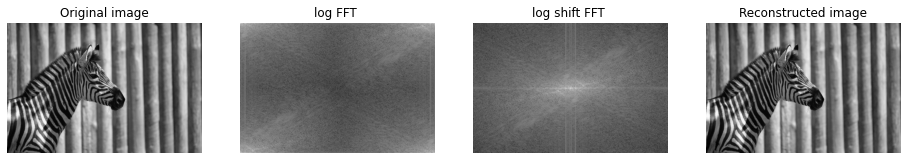

In [18]:
SUBDIR = os.path.join(IMDIR, "Fourier")


for root, dirnames, filenames in os.walk(SUBDIR):
    # print path to all filenames.
    for filename in filenames:
        f = os.path.join(root, filename)
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            print(f)
            im = io.imread(f,as_gray=True)
            #im = resize(im,(100,100),mode='constant') # RESIZE IF TOO SLOW 
    
            
            # FILL IN WITH YOUR CODE HERE
            im_fft = np.fft.fft2(im)
            im_fft_centered = np.fft.fftshift(im_fft)
            
            ftt_no_center=np.fft.ifftshift(im_fft_centered)
            inverse_fft=np.fft.ifft2(ftt_no_center)
            image_recovered=np.real(inverse_fft)
            
            fig=plt.figure(figsize=(16, 18))

            plt.subplot(141)
            plt.title('Original image')
            plt.imshow(im)
            plt.gray()
            plt.axis('off')

            
            plt.subplot(142)
            plt.title('log FFT ')
            plt.imshow(np.log(np.abs(im_fft)))
            plt.gray()
            plt.axis('off')
                        
            plt.subplot(143)
            plt.title('log shift FFT ')
            plt.imshow(np.log(np.abs(im_fft_centered)))
            plt.gray()
            plt.axis('off')

            
            plt.subplot(144)
            plt.title('Reconstructed image')
            plt.imshow(image_recovered)
            plt.gray()
            plt.axis('off')
            
            plt.show()

## 2. Filtering in the frequency domain
**a)** Implement two functions that create a low pass and a high-pass filter frequency space for a given cutoff frequency $D_0$. The functions receive as input parameter the type of filter: 'ideal' or 'gaussian', and the filter parameters.

**b)** Show the filter frequency responses for different values of the cuttoff frequency both for the gaussian and the ideal filters. 

**c)** Filter **ONE** of the images in the ```freqfilt``` folder with the implemented functions. 

**d)** For the image in c) Show the results of the low and high pass filters  both in the frequency and the spatial domain.

**e)** Show and compare the results from the ideal and the Gaussian filter. 
**Question**: Are there any observable differences? (write answers in the ANSWERS block below)

**f)** **Question**: What happens with the DC component after a highpass filter has been applied?

**g)** Design and apply the right filter to do the following tasks:
- remove the noise of ```tower.jpg```
- smooth out the freckles of trying to keep the face sharp ```face1.jpg```
- remove out the moire pattern from  ```car-moire-pattern.tif```
- highlight the wrinkles of ```face2.jpg```
- remove the interference pattern of ```astronaut-interference.tif```
- remove the shadow from the ```text-spotshade.tif```

**Explain** the filter choice, show the spatial and frequency response and comment your findings.


**IN THE REPORT** Answer questions e), f) and g) 


In [93]:
def lowpass_filter(D, shape, filter_type='ideal'):
    Q, P = shape
    if filter_type == 'ideal':
        lowpass = np.array([[int((u - P//2)**2 + (v - Q//2)**2 < D**2) for u in range(P)] for v in range(Q)])
    else:
        lowpass = np.array([[ np.exp(-((u - P//2)**2 + (v - Q//2)**2 )/(2*D**2)) for u in range(P)]for v in range(Q)])
    return lowpass

def highpass_filter(D,shape,filter_type='ideal'):
    Q, P = shape
    if filter_type == 'ideal':
        lowpass = np.array([[int((u - P//2)**2 + (v - Q//2)**2 > D**2) for u in range(P)] for v in range(Q)])
    else:
        lowpass = 1-lowpass_filter(D,shape,'gaussian')
    return lowpass


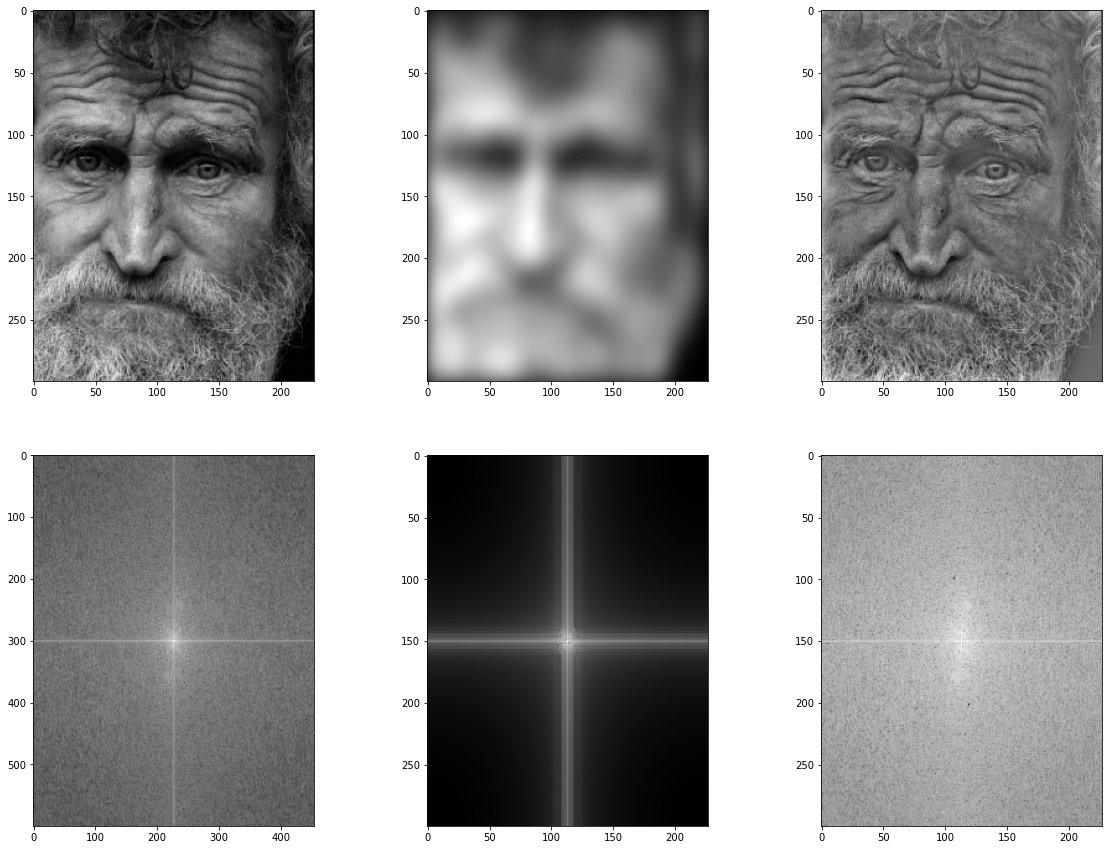

In [135]:
SUBDIR = os.path.join(IMDIR, "Frequency")
f = os.path.join(SUBDIR, "face2.jpg")

im = io.imread(f, as_gray=True)
im = im.astype(float)

#PADDING
N,M = im.shape
pad_im=np.zeros((2*N,2*M))
pad_im[0:N,0:M]=im

#FFT
fft = np.fft.fft2(pad_im)

#CENTER
fft_center = np.fft.fftshift(fft)

#FILTER
D=10
high = highpass_filter(D,pad_im.shape,'g');
low = lowpass_filter(D,pad_im.shape,'g');

#COMPUTE FILTER
fft_low = low*fft_center;
fft_high = high*fft_center;

#INVERT
inverse_fft_low=np.fft.ifftshift(fft_low)
inverse_fft_high=np.fft.ifftshift(fft_high)
    
#REMOVE CENTER
inverse_fft_low=np.fft.ifft2(inverse_fft_low)
inverse_fft_high=np.fft.ifft2(inverse_fft_high)

#REMOVE CENTER
im_low=np.real(inverse_fft_low)
im_high=np.real(inverse_fft_high)

#CROP
final_low=im_low[:N,:M]
final_high=im_high[:N,:M]

#CROP
plt.subplot(2,3,1)
plt.imshow(im, cmap = 'gray')
plt.subplot(2,3,2)
plt.imshow(final_low)
plt.subplot(2,3,3)
plt.imshow(final_high)
plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(fft_center)))
plt.subplot(2,3,5)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(final_low)))))
plt.subplot(2,3,6)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(final_high)))))
plt.show()

##  3. Towards JPEG Compression

**Introduction**

One of the crucial steps of JPEG Compression is the quantization in frequency space. The procedure follows the next steps:

**i)** An image is first subdivided in 8x8 subblocks (assuming the original image has sides whose length is a multiple of 8, if it is not the case just resize it).

**ii)** A frequency transformation is computed for each block (computed with a discrete cosine transform DCT II )
```
fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')
```
**iii)** The DCT results are then divided by the elements of a predefined quantization matrix, then rounded and stored as integers. **Hint:** use functions  ```round()```, ```astype(np.int32)```

**iv)** The result of quantization (which should have many zeros) is then compressed Run Lenght Coding and Huffman coding to reduce the size. The compressed values are saved together with the quantization table.

**v)** The reconstruction of the image implies inverting the encoding, the quantization and the dct.

See more info in this video.
https://www.youtube.com/watch?v=Q2aEzeMDHMA



**What to implement**

In this part you will reproduce the steps regarding the DCT from the JPEG compression procedure, that is steps i) to iii). Pick a grayscale image of your choice, resize it if necessary.

**a)** Compute the frequency quantization step, using the provided ```quantization_table``` and ``dct_2d`` functions.

**b)** Restore the image from its quantized frequency representation.

**c)** Show the frequency spectrum  before and after the quantization.

**d)** Show:
- the original image
- the quantized image 
- the difference between the two.

**e)** Repeat the above steps but resizing the input image to 128,128 first. What do you observe ?

**f)** Replace the given DCT function by your own basis implementation. Explain any difference.


**IN THE REPORT** Comment on your findings for questions d), e) and f)



In [1]:
from skimage.transform import resize
import scipy
from scipy import fftpack


def dct_2d(im):
    return fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')

def idct_2d(im):
    return fftpack.idct(fftpack.idct(im.T, norm='ortho').T, norm='ortho')

def quantization_table(component='lum'):
    # Quantization Table for: Photoshop 
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


im = scipy.misc.ascent().astype(float)
print(im.shape)


(512, 512)


### 4. BONUS: Magnitude and phase of the FFT  

**a)** Load the ```wolf.jpg``` and ```cat.jpg``` images inside the ```PhaseMag``` folder. Use ```im = misc.imresize(im,(100,100))```  to resize the two images such that both have the same size.

**b)** Compute the fft of each image

**c)** Display the centered and logarithmically scaled magnitude of each fft (same as 1.1)

**d)** Compute and display the phase of the fft

**e)** Reconstruct the ```cat``` and the ```wolf``` images only from their **magnitude** (set the phase to 0). Display the result in a logarithmic scale.

**f)** Reconstruct the ```cat``` and the ```wolf``` images only from their **phase** (set the magnitude to 1) 

**g)** Reconstruct an image with the magnitude of the wolf's fft and the phase of the cat's fft. 

**h)** Explain what you observe

**Hints**: You may want use the following functions:
- ```np.abs``` and ```np.angle``` to extract the magnitude and phase of a complex number.
- ```magnitude * np.exp (1j * phase)``` to build a complex number from its magnitude and phase.
- ```np.cos``` and  ```np.sin``` to build a complex number from its real and imaginary part ( $real + 1j*imaginary$)


**IN THE REPORT**: What do we observe and why?